### Backtesting Strategy 2: Intraday Resistance Breakout Strategy

In [1]:
!pip install alpha_vantage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time

In [45]:
# Below are the KPI functions discussed in Key Performance Measures section
def ATR(DF, n):
  "function to calculate True Range and Average True Range"
  df = DF.copy()
  df['H-L'] = abs(df['High'] - df['Low'])
  df['H-PC'] = abs(df['High']-df['Close'].shift(1))
  df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
  df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
  df['ATR'] = df['TR'].rolling(n).mean()
  df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
  return df2['ATR']

def CAGR(DF):
  # Function to implement the Cumulative Average Annual Growth Rate of a trading strategy
  df = DF.copy()
  df['cum_return'] = (1+df['ret']).cumprod()
  n = len(df)/(252*78) # 78 is the number of 5 min candles in day from 9:35 AM to 4:00 PM, 252 is the number of working days in a year (excluding holidays)
  CAGR = (df['cum_return'].tolist()[-1])**(1/n) - 1
  return CAGR

def volatility(DF):
  # function to calculate annualized volatility of a trading strategy
  df = DF.copy()
  vol = df['ret'].std()*np.sqrt(252*78)
  return vol

def sharpe(DF, rf):
  # function to calculate sharpe ratio; rf is the risk free rate
  df = DF.copy()
  sr = (CAGR(df) - rf)/volatility(df)
  return sr

def max_dd(DF):
  # function to calculate max drawdown
  df = DF.copy()
  df['cum_return'] = (1+df['ret']).cumprod()
  df['cum_roll_max'] = df['cum_return'].cummax()
  df['drawdown'] = df['cum_roll_max'] - df['cum_return']
  df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
  max_dd = df['drawdown_pct'].max()
  return max_dd

In [16]:
# Download historical data (monthly) for selected stocks
tickers = ['MSFT', 'AAPL', 'META', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'TSLA', 'AMD']

ts = TimeSeries(key='U1F2EWT19UKN9RXR', output_format='pandas')

ohlc_intraday = {} # directory with ohlc value for each stock
api_call_count = 1
start_time = time.time()

for ticker in tickers:
  data = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')[0]
  api_call_count += 1
  data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  data = data.iloc[::-1]
  data = data.between_time('09:35', '16:00') # consider data within regular trading hours, first candle is from 9:30 
  ohlc_intraday[ticker] = data
  if api_call_count==5:
    api_call_count = 1
    time.sleep(60 - ((time.time() - start_time) % 60.0))

tickers = ohlc_intraday.keys() #redefine ticker variable after removing any tickers with corrupted data

In [17]:
tickers

dict_keys(['MSFT', 'AAPL', 'META', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'TSLA', 'AMD'])

### Implementation of BackTesting Strategy: Intraday Resistance Breakout

In [39]:
# Calculating rolling max ratio and ATR for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
  print("Calculating ATR and Rolling Max price for ", ticker)
  ohlc_dict[ticker]['ATR'] = ATR(ohlc_dict[ticker], 20)
  ohlc_dict[ticker]['roll_max_cp'] = ohlc_dict[ticker]['High'].rolling(20).max()
  ohlc_dict[ticker]['roll_min_cp'] = ohlc_dict[ticker]['Low'].rolling(20).min()
  ohlc_dict[ticker]['roll_max_vol'] = ohlc_dict[ticker]['Volume'].rolling(20).max()
  ohlc_dict[ticker].dropna(inplace=True)
  tickers_signal[ticker] = ""
  tickers_ret[ticker] = [0]

Calculating ATR and Rolling Max price for  MSFT
Calculating ATR and Rolling Max price for  AAPL
Calculating ATR and Rolling Max price for  META
Calculating ATR and Rolling Max price for  AMZN
Calculating ATR and Rolling Max price for  INTC
Calculating ATR and Rolling Max price for  CSCO
Calculating ATR and Rolling Max price for  VZ
Calculating ATR and Rolling Max price for  IBM
Calculating ATR and Rolling Max price for  TSLA
Calculating ATR and Rolling Max price for  AMD


In [40]:
# Identifying signals and calculating return (stop loss factored in)
for ticker in tickers:
  print("Calculating returns for ", ticker)
  for i in range(1, len(ohlc_dict[ticker])):
    if tickers_signal[ticker] == "":
      tickers_ret[ticker].append(0)
      if ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]['roll_max_cp'][i] and ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]['roll_max_vol'][i-1]:
        tickers_signal[ticker] = "Buy"
      elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]['roll_min_cp'][i] and ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]['roll_max_vol'][i-1]:
        tickers_signal[ticker] = "Sell"

    elif tickers_signal[ticker] == "Buy":
      if ohlc_dict[ticker]['Low'][i] < ohlc_dict[ticker]['Close'][i-1] - ohlc_dict[ticker]['ATR'][i-1]:
        tickers_signal[ticker] = ""
        tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]['ATR'][i-1])/ohlc_dict[ticker]['Close'][i-1]) -1)
      elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]['roll_min_cp'][i] and ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]['roll_max_vol'][i-1]:
        tickers_signal[ticker] = "Sell"
        tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i]/ohlc_dict[ticker]['Close'][i-1])-1)
      else:
        tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i]/ohlc_dict[ticker]['Close'][i-1])-1)

    elif tickers_signal[ticker] == "Sell":
      if ohlc_dict[ticker]["High"][i] > ohlc_dict[ticker]['Close'][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
        tickers_signal[ticker] = ""
        tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1] / (ohlc_dict[ticker]['Close'][i-1] + ohlc_dict[ticker]['ATR'][i-1])) -1)
      elif ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]['roll_max_cp'][i] and ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]['roll_max_vol'][i-1]:
        tickers_signal[ticker] = "Buy"
        tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i-1]/ohlc_dict[ticker]['Close'][i])-1)
      else:
        tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i-1]/ohlc_dict[ticker]['Close'][i])-1)
  ohlc_dict[ticker]['ret'] = np.array(tickers_ret[ticker])

Calculating returns for  MSFT
Calculating returns for  AAPL
Calculating returns for  META
Calculating returns for  AMZN
Calculating returns for  INTC
Calculating returns for  CSCO
Calculating returns for  VZ
Calculating returns for  IBM
Calculating returns for  TSLA
Calculating returns for  AMD


In [46]:
# Calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
  strategy_df[ticker] = ohlc_dict[ticker]['ret']
strategy_df['ret'] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df, 0.025))
print(max_dd(strategy_df))

0.143096684977009
2.969787734073608
0.006329244655629976


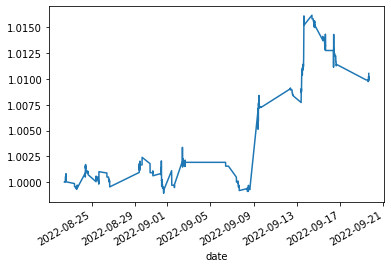

In [47]:
# Visualization of strategy return
(1+strategy_df['ret']).cumprod().plot()

In [48]:
# Calculating individual Stock KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("Calculating KPIs for ", ticker)
    cagr[ticker] = CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] = sharpe(ohlc_dict[ticker], 0.025)
    max_drawdown[ticker] = max_dd(ohlc_dict[ticker])

Calculating KPIs for  MSFT
Calculating KPIs for  AAPL
Calculating KPIs for  META
Calculating KPIs for  AMZN
Calculating KPIs for  INTC
Calculating KPIs for  CSCO
Calculating KPIs for  VZ
Calculating KPIs for  IBM
Calculating KPIs for  TSLA
Calculating KPIs for  AMD


In [49]:
KPI_df = pd.DataFrame([cagr, sharpe_ratios, max_drawdown], index=['Return', 'Sharpe Ratio', 'Max Drawdown'])
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,0.307292,3.048598,0.018593
AAPL,0.348541,4.778942,0.009567
META,0.289377,2.095825,0.037226
AMZN,0.173568,1.624170,0.010123
INTC,-0.024027,-0.586061,0.019677
CSCO,0.159502,2.066065,0.012515
VZ,-0.147883,-4.125384,0.015699
IBM,-0.050184,-1.981650,0.009582
TSLA,0.206766,1.834363,0.026657
AMD,0.277699,2.788369,0.022030
